In [2]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm  # For progress bar
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load previously saved DataFrames
business_df = pd.read_parquet("../Data/business_df.parquet")
review_df = pd.read_parquet("../Data/review_df.parquet")
user_df = pd.read_parquet("../Data/user_df.parquet")

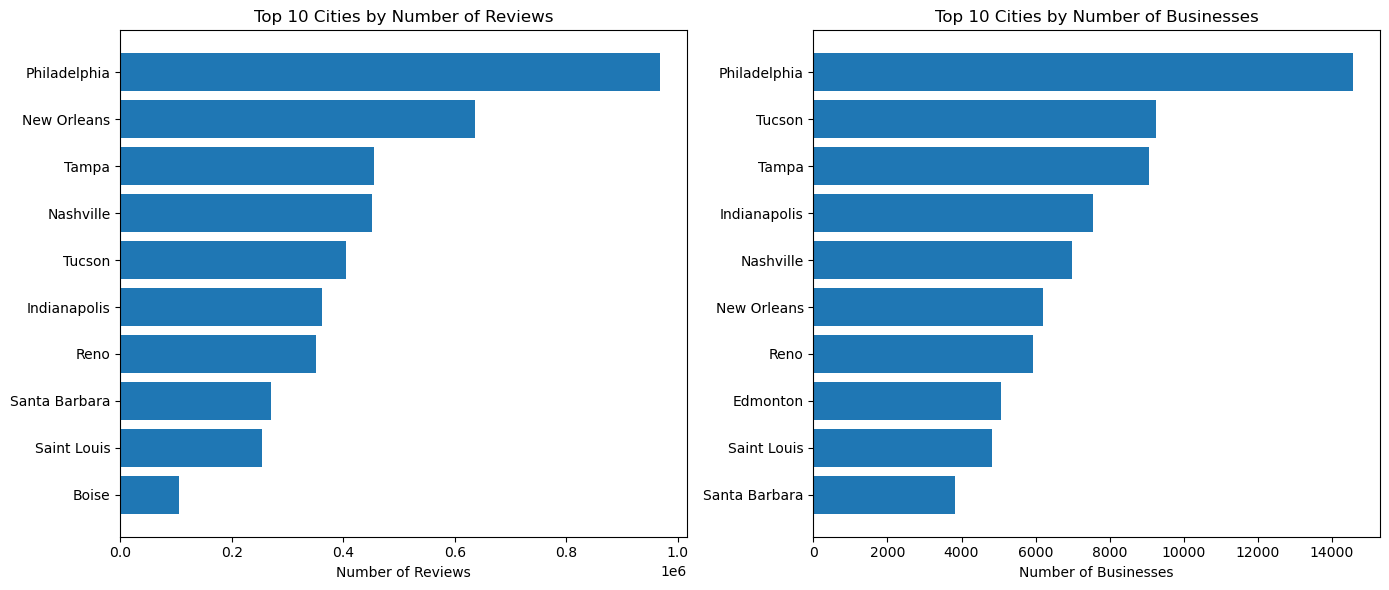

In [4]:
# Count businesses per city
business_counts = business_df.groupby('city')['business_id'].nunique().reset_index(name='num_businesses')

# Merge review data with business to get city info
review_with_city = pd.merge(
    review_df[['business_id', 'review_id']],
    business_df[['business_id', 'city']],
    on='business_id',
    how='left'
)

# Count reviews per city
review_counts = review_with_city.groupby('city')['review_id'].count().reset_index(name='num_reviews')

# Combine
city_stats = pd.merge(business_counts, review_counts, on='city')
city_stats['reviews_per_business'] = city_stats['num_reviews'] / city_stats['num_businesses']

# Sort by number of reviews
top_by_reviews = city_stats.sort_values(by='num_reviews', ascending=False).head(10)

# Sort by number of businesses
top_by_businesses = city_stats.sort_values(by='num_businesses', ascending=False).head(10)

# Plotting
plt.figure(figsize=(14, 6))

# Top by Reviews
plt.subplot(1, 2, 1)
plt.barh(top_by_reviews['city'][::-1], top_by_reviews['num_reviews'][::-1])
plt.title('Top 10 Cities by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.tight_layout()

# Top by Businesses
plt.subplot(1, 2, 2)
plt.barh(top_by_businesses['city'][::-1], top_by_businesses['num_businesses'][::-1])
plt.title('Top 10 Cities by Number of Businesses')
plt.xlabel('Number of Businesses')
plt.tight_layout()

plt.show()


In [5]:
# Step 1: Filter Philadelphia businesses
philly_businesses = business_df[business_df['city'].str.lower() == 'philadelphia']
philly_ids = set(philly_businesses['business_id'])

In [6]:
# Step 2: Filter reviews for Philadelphia businesses
philly_reviews = review_df[review_df['business_id'].isin(philly_ids)].copy()
philly_reviews = philly_reviews.dropna(subset=["text"])

In [7]:
# Step 3: Sample reviews (adjust `n` for testing or scale up later)
sample_reviews = philly_reviews.sample(n=3000, random_state=42).reset_index(drop=True)

In [8]:
# Step 2: Load zero-shot pipeline
print("Loading smaller, faster zero-shot classification model...")
classifier = pipeline(
    "zero-shot-classification",
    model="typeform/distilbert-base-uncased-mnli",
    device=-1  # CPU
)
print("Model loaded.\n")

Loading smaller, faster zero-shot classification model...


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Device set to use cpu


Model loaded.



In [9]:
# Mood labels
mood_labels = ["Adventurous", "Comforting", "Energizing", "Romantic", "Trendy", "Healthy", "Fun"]

# Step 3: Process reviews in small batches
print(f"🔍 Classifying {len(sample_reviews)} reviews...")
texts = sample_reviews['text'].tolist()
results = []

batch_size = 10
for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    try:
        batch_results = classifier(batch, candidate_labels=mood_labels, multi_label=True, truncation=True)
        results.extend(batch_results)
    except Exception as e:
        print(f"⚠️ Batch error {i}: {e}")
        for _ in batch:
            results.append({'labels': [], 'scores': []})

🔍 Classifying 3000 reviews...


100%|██████████| 300/300 [56:13<00:00, 11.24s/it]


In [10]:
# Step 4: Add mood scores back to DataFrame
sample_reviews['mood_scores'] = [dict(zip(r["labels"], r["scores"])) if r["labels"] else {} for r in results]

In [11]:
# Ensure all results are valid mood dictionaries
mood_dicts = []
for r in results:
    if isinstance(r, dict) and 'labels' in r and 'scores' in r:
        mood_dicts.append(dict(zip(r["labels"], r["scores"])))
    else:
        mood_dicts.append({})  # fallback if something went wrong

sample_reviews['mood_scores'] = mood_dicts


In [12]:
# Step 6: Print a few review-level results
print("\n🔍 Sample classified reviews:")
for i, row in sample_reviews[['text', 'mood_scores']].head(5).iterrows():
    print(f"\nReview {i}:\n{row['text'][:250]}...\nMood Scores: {row['mood_scores']}")



🔍 Sample classified reviews:

Review 0:
Normally I am a big fan of Legal's restaurants. Although expensive, seafood is great and lives up to reputation as superior restaurant.  I was traveling on Sunday out of Philadelphia airport and had heard they had good breakfasts, especially the eggs...
Mood Scores: {'Adventurous': 0.7820496559143066, 'Trendy': 0.521041214466095, 'Fun': 0.3446129262447357, 'Healthy': 0.29001545906066895, 'Comforting': 0.20266495645046234, 'Energizing': 0.15607798099517822, 'Romantic': 0.12100030481815338}

Review 1:
Pizza is one of those rare cravings that still comes up often since becoming largely plant-based, but it's generally hard to satisfy as vegan pizza typically just doesn't hit the same. 20th Street Pizza is a different story. Perfectly creamy cheese w...
Mood Scores: {'Adventurous': 0.4413294494152069, 'Comforting': 0.23802964389324188, 'Energizing': 0.2137029767036438, 'Fun': 0.15137116611003876, 'Romantic': 0.07694552093744278, 'Trendy': 0.025402199

In [13]:
# Step 7: Aggregate scores by business
def aggregate_scores(series):
    total = {}
    for mood_dict in series:
        if isinstance(mood_dict, dict):
            for mood, score in mood_dict.items():
                total[mood] = total.get(mood, 0) + score
    return total

# CORRECT: group by business_id and apply to full DataFrame
mood_by_business = (
    sample_reviews
    .groupby('business_id')
    .apply(lambda df: aggregate_scores(df['mood_scores']))
    .reset_index(name='aggregated_moods')
)


In [14]:
print(mood_by_business['aggregated_moods'].iloc[0])
print(type(mood_by_business['aggregated_moods'].iloc[0]))



{'Healthy': 0.898189127445221, 'Comforting': 0.6939252614974976, 'Adventurous': 0.6934230327606201, 'Fun': 0.6098827123641968, 'Trendy': 0.43268147110939026, 'Energizing': 0.43142396211624146, 'Romantic': 0.034490834921598434}
<class 'dict'>


In [15]:
# Step 8: Assign each business just ONE top mood based on average mood score
def get_top_mood_and_score(mood_dict):
    if isinstance(mood_dict, dict) and mood_dict:
        top_mood = max(mood_dict.items(), key=lambda x: x[1])
        return pd.Series({'top_mood': top_mood[0], 'top_mood_score': top_mood[1]})
    return pd.Series({'top_mood': None, 'top_mood_score': None})

# Apply to your mood_by_business DataFrame
mood_by_business = mood_by_business.copy()
mood_by_business[['top_mood', 'top_mood_score']] = mood_by_business['aggregated_moods'].apply(get_top_mood_and_score)


In [16]:
# Step 9: Join with business data
philly_profiles = pd.merge(philly_businesses, mood_by_business, on='business_id', how='inner')

print(philly_profiles[['name', 'aggregated_moods', 'top_mood']].head(10))


                                      name  \
0                                 Tuna Bar   
1                                  Wendy's   
2                        ReAnimator Coffee   
3                         Shanghai Station   
4        City Fitness - Northern Liberties   
5               Aloft Philadelphia Airport   
6  Chinatown Market Shoe Repair And Tailor   
7                                   Acadia   
8                     Marino's Auto Repair   
9                                 The Love   

                                    aggregated_moods     top_mood  
0  {'Healthy': 0.0038615488447248936, 'Adventurou...      Healthy  
1  {'Energizing': 0.08850815892219543, 'Adventuro...   Energizing  
2  {'Healthy': 0.06018088385462761, 'Adventurous'...      Healthy  
3  {'Healthy': 0.947182834148407, 'Trendy': 0.871...      Healthy  
4  {'Adventurous': 0.44104304909706116, 'Trendy':...  Adventurous  
5  {'Comforting': 0.9839684367179871, 'Healthy': ...   Comforting  
6  {'Comforting':

In [17]:
print(mood_by_business.head(5))
print(mood_by_business['aggregated_moods'].apply(type).value_counts())



              business_id                                   aggregated_moods  \
0  -0M0b-XhtFagyLmsBtOe8w  {'Healthy': 0.898189127445221, 'Comforting': 0...   
1  -0TffRSXXIlBYVbb5AwfTg  {'Comforting': 2.0611733198165894, 'Fun': 2.05...   
2  -2-ih3mE8KPyeKVIzpBfPQ  {'Comforting': 0.3346126973628998, 'Healthy': ...   
3  -32hOCwsuKd04WO-HQyYFg  {'Adventurous': 0.3386179804801941, 'Fun': 0.2...   
4  -3e3CP3FFc-rvJj_-_airw  {'Adventurous': 0.8112845420837402, 'Fun': 0.5...   

      top_mood  top_mood_score  
0      Healthy        0.898189  
1      Healthy        2.242098  
2   Comforting        0.334613  
3  Adventurous        0.338618  
4  Adventurous        0.811285  
<class 'dict'>    2015
Name: aggregated_moods, dtype: int64


In [18]:
def format_mood_dict(mood_dict):
    if not isinstance(mood_dict, dict):
        return ""
    sorted_moods = sorted(mood_dict.items(), key=lambda x: x[1], reverse=True)
    return ", ".join([f"{mood}: {score:.2f}" for mood, score in sorted_moods])


In [19]:
# Filter only restaurant businesses in Philly
philly_businesses = business_df[
    (business_df['city'].str.lower() == 'philadelphia') &
    (business_df['categories'].fillna('').str.contains("Restaurants", case=False))
]

# Merge with mood data
philly_profiles = pd.merge(philly_businesses, mood_by_business, on="business_id", how="inner")

# Format for display
philly_profiles['mood_summary'] = philly_profiles['aggregated_moods'].apply(format_mood_dict)

# Show top 10 restaurant mood profiles
philly_profiles[['name', 'address', 'stars', 'review_count', 'top_mood', 'mood_summary']].head(10)


,name,address,stars,review_count,top_mood,mood_summary
0,Tuna Bar,205 Race St,4.0,245,Healthy,"Healthy: 0.00, Adventurous: 0.00, Trendy: 0.00..."
1,Wendy's,700 E. Hunting Park,1.5,15,Energizing,"Energizing: 0.09, Adventurous: 0.00, Fun: 0.00..."
2,Shanghai Station,4002 Spruce St,4.0,46,Healthy,"Healthy: 0.95, Trendy: 0.87, Energizing: 0.85,..."
3,Acadia,824 S 8th St,4.0,79,Healthy,"Healthy: 0.06, Adventurous: 0.04, Fun: 0.01, C..."
4,The Love,130 S 18th St,4.0,618,Healthy,"Healthy: 2.47, Fun: 2.43, Adventurous: 2.37, C..."
5,Jong Ka Jib,6600 N 5th St,4.5,351,Fun,"Fun: 0.86, Comforting: 0.84, Trendy: 0.64, Hea..."
6,The Twisted Tail,509 S 2nd St,4.0,604,Healthy,"Healthy: 1.64, Comforting: 1.47, Trendy: 1.42,..."
7,Chick-fil-A,9711 Roosevelt Blvd,4.0,80,Comforting,"Comforting: 1.00, Energizing: 1.00, Healthy: 1..."
8,Morton's The Steakhouse,1411 Walnut St,3.5,149,Fun,"Fun: 0.75, Comforting: 0.69, Adventurous: 0.60..."
9,Wawa,3744 Spruce St,3.5,50,Energizing,"Energizing: 0.14, Adventurous: 0.07, Trendy: 0..."


In [20]:
def format_review_moods(mood_dict):
    if not isinstance(mood_dict, dict):
        return ""
    sorted_moods = sorted(mood_dict.items(), key=lambda x: x[1], reverse=True)
    return ", ".join([f"{m}: {s:.2f}" for m, s in sorted_moods[:3]])

# Show full text instead of slice
sample_reviews['text_preview'] = sample_reviews['text']  # or use .str.slice(0, 1000)
sample_reviews['mood_summary'] = sample_reviews['mood_scores'].apply(format_review_moods)

# Display
sample_reviews[['text_preview', 'stars', 'mood_summary']].head(10)

,text_preview,stars,mood_summary
0,Normally I am a big fan of Legal's restaurants...,2.0,"Adventurous: 0.78, Trendy: 0.52, Fun: 0.34"
1,Pizza is one of those rare cravings that still...,5.0,"Adventurous: 0.44, Comforting: 0.24, Energizin..."
2,Moved to roxborough 9 months ago and me and My...,5.0,"Adventurous: 0.45, Fun: 0.37, Healthy: 0.37"
3,"Pros: \n- Great, simple store layout\n- Differ...",5.0,"Healthy: 0.69, Comforting: 0.36, Adventurous: ..."
4,What a bad joke! Horrible service! They advert...,1.0,"Energizing: 0.05, Adventurous: 0.04, Fun: 0.02"
5,"I never write Yelp reviews, I generally use it...",2.0,"Adventurous: 0.53, Energizing: 0.30, Fun: 0.27"
6,A charming place where the only thing better t...,5.0,"Comforting: 0.04, Adventurous: 0.04, Fun: 0.03"
7,The tour was AWESOME! If you are into history ...,5.0,"Fun: 1.00, Adventurous: 0.99, Trendy: 0.99"
8,Hard to go wrong with Rembrandt's. Close to th...,4.0,"Healthy: 0.08, Trendy: 0.03, Adventurous: 0.01"
9,Fun and tasty meal. Rice is bomb. Would come b...,4.0,"Fun: 0.93, Trendy: 0.72, Adventurous: 0.72"


In [21]:
import gradio as gr

# ✅ Filter mood_by_business to include only restaurant businesses
valid_ids = set(philly_businesses['business_id'])  # philly_businesses should already be filtered to restaurants
mood_by_business = mood_by_business[mood_by_business['business_id'].isin(valid_ids)]

# ✅ Function to recommend restaurant based on mood
def recommend_restaurant(selected_mood):
    print(f"⚡ Function called with mood: {selected_mood}")

    # Step 1: Filter to businesses with that mood
    filtered = mood_by_business[
        mood_by_business['top_mood'] == selected_mood
    ]


    print(f"✅ Filtered businesses found: {len(filtered)}")

    if filtered.empty:
        return f"No restaurants found for the mood '{selected_mood}'."

    # Step 2: Sort by mood score and pick top result
    filtered['score'] = filtered['aggregated_moods'].apply(lambda d: d[selected_mood])

    # Count how many reviews this business has with that mood
    mood_counts = sample_reviews[sample_reviews['mood_scores'].apply(
        lambda d: isinstance(d, dict) and selected_mood in d
    )].groupby('business_id').size()

    filtered['mood_review_count'] = filtered['business_id'].map(mood_counts).fillna(0)

    # Compute weighted score (score * log of review count + 1)
    import numpy as np
    filtered['weighted_score'] = filtered['score'] * np.log1p(filtered['mood_review_count'])

    top = filtered.sort_values(by='weighted_score', ascending=False).iloc[0]

    print(f"🍽️ Selected restaurant ID: {top['business_id']} with mood score: {top['score']:.2f}")

    # Step 3: Get business info
    biz_id = top['business_id']
    biz_row = philly_businesses[philly_businesses['business_id'] == biz_id]
    if biz_row.empty:
        return "Found matching mood, but couldn't look up restaurant details."

    biz = biz_row.iloc[0]
    name = biz['name']
    address = biz['address']
    stars = biz['stars']
    review_count = biz['review_count']
    categories = biz['categories']

    # Step 4: Sample reviews for that business
    related_reviews = sample_reviews[sample_reviews['business_id'] == biz_id]
    matching_reviews = related_reviews[related_reviews['mood_scores'].apply(
        lambda d: isinstance(d, dict) and selected_mood in d)]

    print(f"💬 Matching reviews found: {len(matching_reviews)}")

    # ✅ Sort by score properly
    matching_reviews["score"] = matching_reviews["mood_scores"].apply(lambda d: d[selected_mood])
    top_reviews = matching_reviews.sort_values(by="score", ascending=False).head(3)

    review_texts = "\n\n".join([
        f"⭐ {row['stars']}: {row['text'][:500]}..." for _, row in top_reviews.iterrows()
    ])

    return f"""
## 🍽️ {name}
**📍 Address**: {address}  
**⭐ Rating**: {stars} stars from {review_count} reviews  
**📂 Categories**: {categories}  

### 🧠 Why we picked it:
This restaurant had the highest `{selected_mood}` mood score from our model!

---

### 💬 Top Reviews Matching Your Mood:

{review_texts if review_texts else 'No matching reviews found.'}
"""

# ✅ Set up and launch Gradio app
gr.Interface(
    fn=recommend_restaurant,
    inputs=gr.Dropdown(
        choices=["Adventurous", "Comforting", "Energizing", "Romantic", "Trendy", "Healthy", "Fun"],
        label="What's your mood?"
    ),
    outputs=gr.Markdown(),
    title="🌟 Philly Restaurant Mood Matcher",
    description="Choose a mood and get a restaurant recommendation based on Yelp reviews."
).launch(inline=True, share=False)


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
